In [22]:
####################################################################################################################
# Initial Code source by:                Gaël Varoquaux
#                                        Andreas Müller
# Modified for documentation by:         Jaques Grobler
# Mainly Modified for private usage by:  Ioannis Agriomallos
# License: BSD 3 clause
####################################################################################################################
######==================== CURRENT CODE USAGE ======================================================================
# -> Current code trains several ML Classifiers, to classify force input samples as stable (0) or slip (1)
######---- Input
# -> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 3 different datasets, 
# containing several surfaces as well as slip-stable occurrences
######---- Input transformation
# -> Several pre-features are taken from these inputs.
# -> Several time and frequency domain features are extracted from pre-feature windows. 
# (implemented in 'newfeatext.py') These windows have size w and are shifted by s on each sample
# -> Then a feature selection-ranking is performed using MutualVariableInformation
# -> Finally PCA is performed to keep the desired among the best selected features
######---- Training of ML Classifiers
# -> Several ML Classifiers are trained for all combinations of features-datasets
######---- Stats report
# -> Several stats are reported on the classification results of the trained models, 
# based on their accuracy (fscore and auc as well) on test data as well as previously unseen data
######===================== POTENTIAL CODE EXTENSION FOR FURTHER MORE GENERIC USAGE ================================
# -> As binary classification problem it may apply to all such problems given that:
######----- Input
# -> Input is loaded on datasets, which expect (n,1) input with (k,4) dimensions each,
# where n data samples, k measurement in each sample, 3 force readings and 1 label for each measurement.
######----- Input transformation
# -> Pre-features must be changed or ommitted to fit your needs. 
# Here they served to transform the 3 (fx,fy,fz) force readings into one between (ft,fn,ft/fn,sf)
# -> Features are performed on the desired pre-features. They take a (n,o,m) input matrix and return a (n,o,l),
# where n data samples, o windows, m prefeatures, l features.
# -> Feature selection gives a ranking on each l, so we keep b from the best
# -> PCA is performed on the b selected features resulting in p dimensions (n,o,p) => (n*o,p)
######----- Training of ML Classifiers
# -> Each Classifier is trained on a subset of (n*o,p)
######----- Stats
# -> Change accordingly!
####################################################################################################################
print(__doc__)
import time
start_time = time.time()
from copy import deepcopy
import math
import scipy.io as sio
import shutil
import os
from random import shuffle
import numpy as np
#from pylab import *
from featext import feat
import matplotlib.pyplot as plt
%matplotlib inline 
#matplotlib qt
# inline (suitable for ipython only, shown inside browser!) or qt (suitable in general, shown in external window!)
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D #, axes3d
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RandomizedLasso
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score, roc_auc_score
from collections import OrderedDict
import re
import datetime
import urllib
import tarfile

h = .2  # step size in the mesh

names = ["NearNb", "LinSVM", "RBFSVM", "NaiveBayes", "LDA",
         "QDA", "MLP", "Lasso", "Lin.Regr", "Log.Regr", "Dec.Tree",
         "RandFor", "AdaBoost", "EnsembleMLP"]
classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(solver='lbfgs',alpha=1e-4,hidden_layer_sizes=(10,2),random_state=1,verbose=True),
    LassoCV(),
    LinearRegression(),
    LogisticRegression(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(len(names)-1,2),random_state=1,max_iter=500)
    #VotingClassifier()
]
metric = ['accuracy','f1']
dataset = 0 # all datasets (0), dataset 1-2 (1), dataset 3 (2)
download = 1 # Download pre-computed (1) data or compute them anew (0)

Automatically created module for IPython interactive environment


In [2]:
########################################## Download necessary files ################################################
if download==1:
    downpath = "features/"
    downfile = downpath+"features.tar.gz"
    downlink = "https://www.dropbox.com/s/lx3ggezzq2wl2km/features.tar.gz?dl=1"
    if not os.path.isfile(downfile):
        u = urllib.urlopen(downlink)
        data = u.read()
        print 'Completed downloading ',len(data)*1./(1024**3),'GB of ',downfile,'!'
        u.close()
        with open(downfile, "wb") as f :
            f.write(data)
        if (downfile.endswith("tar.gz")):
            tar = tarfile.open(downfile, "r:gz")
            tar.extractall(path=downpath)
            tar.close()
        print 'Completed extracting files!'
    else:
        print 'Necessary files already here!'
########################################## Download necessary datasets #############################################
datafiles1 = 'slipdataset12.mat'
if not os.path.isfile(datafiles1):
    downdata1 = "https://www.dropbox.com/s/w8y0rlg9kj6axxt/slipdataset12.mat?dl=1"
    u = urllib.urlopen(downdata1)
    data = u.read()
    print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',datafiles1,'!'
    u.close()
    with open(datafiles1, "wb") as f :
        f.write(data)
else:
    print 'Necessary ',datafiles1,' already here!'
datafiles2 = 'slipdataset3_C.mat'
if not os.path.isfile(datafiles2):
    downdata2 = "https://www.dropbox.com/s/95znajbu6sga8iz/slipdataset3_C.mat?dl=1"
    u = urllib.urlopen(downdata2)
    data = u.read()
    print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',datafiles2,'!'
    u.close()
    with open(datafiles2, "wb") as f :
        f.write(data)
else:
    print 'Necessary ',datafiles2,' already here!'
########################################## Download pretrained ML Classifiers models ###############################    
clfmodelfile = 'trained_classifiers.npz'
if not os.path.isfile(clfmodelfile):
    downclf = "https://www.dropbox.com/s/po9m048ukqt1ahn/trained_classifiers.npz?dl=1"
    u = urllib.urlopen(downclf)
    data = u.read()
    print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',clfmodelfile,'!'
    u.close()
    with open(clfmodelfile, "wb") as f :
        f.write(data)
else:
    print clfmodelfile,' already here!'

Necessary files already here!
Necessary  slipdataset12.mat  already here!
Necessary  slipdataset3_C.mat  already here!
trained_classifiers.npz  already here!


In [3]:
########################################## READ THE DATASETS #######################################################
####################### DATASET 1-2, including slip instances for pillbox object ###################################
inp = sio.loadmat(datafiles1,struct_as_record=True)
f1 = inp['f1'] # 1st optoforce
# f2 = inp['f2'] # 2nd optoforce
l1 = inp['label1'] # corresponding labels
# l2 = inp['label2']
f1d = inp['detail1'] # summary of each dataset 
lmat1 = np.zeros(f1.shape[0]) # material label
print 1,f1.shape, l1.shape, lmat1.shape
################ DATASET 3, including slip instances for several surfaces (see f3d for details) ####################
inp3 = sio.loadmat(datafiles2,struct_as_record=True)
f3 = inp3['f3'] # 1st optoforce
f3 = np.array([fi[0][:,:-1] for fi in f3])[:,np.newaxis]
l31 = inp3['label3_cmd'] # corresponding label from commanded slip (1) or stay (0)
# l32 = inp['label3_vel'] # corresponding measured tip velocity
# l33 = inp['label3_acc'] # corresponding measured tip acceleration
f3d = inp3['detail3'] # summary of each dataset
lmat3 = np.array([1,2,2,2,3,2,4]) # material label, for dataset3
print 2,f3.shape, l31.shape, lmat3.shape
########################################### MERGE THE DATASETS #####################################################
if dataset == 0: # use both datasets
    f = np.concatenate((f1,f3),axis=0)
    l = np.concatenate((l1,l31),axis=0)
    fd = np.concatenate((f1d,f3d),axis=0)
    lmat = np.concatenate((lmat1,lmat3),axis=0)
elif dataset == 1: # use dataset 1-2
    f = f1
    l = l1
    fd = f1d
    lmat = lmat1
else:              # use dataset 3
    f = f3
    l = l31
    fd = f3d
    lmat = lmat3
print 3,f.shape,l.shape,lmat.shape
####################################### INDECES for dataset 1-2 ####################################################
# all indeces
ind = range(f.shape[0])
# indexes for rolling
indroll = [16,17,21,22] # during pure stable dataset
# indexes for disturbance
inddist = [12,26]       # ind:12 for pure stable and ind:26 for pure slip dataset 
# indexes for rotation
indrot = [25,31]        # during pure slip dataset
# indexes for circular induced slippage
indcirc = [32,33]       # during pure slip dataset
# kept indeces
nind = np.delete(ind,indroll+inddist)#+indrot+indcirc)
f = f[nind]
l = l[nind]
print 4,f.shape, l.shape
########################################### MERGE f and l ##########################################################
f = np.array([np.concatenate((f[i,0],l[i,0]),axis=1) for i in range(len(f))])
print 5,f.shape,":",[fi.shape for fi in f]

1 (34, 1) (34, 1) (34,)
2 (7, 1) (7, 1) (7,)
3 (41, 1) (41, 1) (41,)
4 (35, 1) (35, 1)
5 (35,) : [(2498, 4), (2498, 4), (2496, 4), (2484, 4), (4094, 4), (5747, 4), (6169, 4), (5163, 4), (6280, 4), (10019, 4), (12642, 4), (5769, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (40018, 4), (39994, 4), (40004, 4), (39852, 4), (39946, 4), (31082, 4), (39896, 4)]


In [4]:
######################################## INITIALISATION PARAMETERS #################################################
window, shift = 1024, 10
havelabel= 0
featlabel = 0         # 0: all features, 1: temporal, 2: frequency, 3: FFT only
magnFFT = 0           # 0: FFT in magnitude format, 1: FFT in real and imag format, 
featall = 0           # 0: all, 1: feat1 (phinyomark's), 2: feat2 (golz's)
featparam = [havelabel,featlabel,magnFFT,featall]
metr = metric[0]      # 0: accuracy, 1: f1score
CV = 5                # cross validation checks
prefeatid = [0,3,4]   # only the prefeatures with corresponding ids will be computed

In [5]:
########################################### PRE-FEATURES ###########################################################
############# DEFINITION
# featnum 0 : sf    = (fx^2+fy^2+fz^2)^0.5
#         1 : ft    = (fx^2+fy^2)^0.5
#         2 : fn    = |fz|
#         3 : ft/fn = (fx^2+fy^2)^0.5/|fz|
# input (nxm) -> keep (nx3) -> compute pre-feature and return (nx1)
def sf(f):
    return np.power(np.sum(np.power(f[:,:3],2),axis=1),0.5)
def ft(f):
    return np.power(np.sum(np.power(f[:,:2],2),axis=1),0.5)
def fn(f):
    return np.abs(f[:,2])
def ftn(f):
    return np.divide(ft(f),fn(f)+np.finfo(float).eps)
def lab(f):
    return np.abs(f[:,-1])
prefeatfn = np.array([sf,ft,fn,ftn,lab]) # convert to np.array to be easily indexed by a list
############# COMPUTATION
prefeat = np.array([np.array([prfn(f[i]) for prfn in prefeatfn[prefeatid]]).transpose() for i in range(len(f))])
print prefeat.shape,":",[p.shape for p in prefeat]

(35,) : [(2498, 3), (2498, 3), (2496, 3), (2484, 3), (4094, 3), (5747, 3), (6169, 3), (5163, 3), (6280, 3), (10019, 3), (12642, 3), (5769, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (40018, 3), (39994, 3), (40004, 3), (39852, 3), (39946, 3), (31082, 3), (39896, 3)]


In [6]:
############################################# FEATURE COMPUTATION ##################################################
featname = 'newfeatures'+'_'+str(window)+'_'+str(featlabel)+'_'+str(magnFFT)+'_'+str(shift)+'_'+str(featall)
featfile = 'features/'+featname+'.npz'
XYfile = 'features/'+featname+'_XY.npz'
XYnormfile = 'features/'+featname+'_XYnorm.npz'
if os.path.isfile(XYfile):
    print "Continuing to XY values..."
else:
    if os.path.isfile(featfile):
        start_time = time.time()
        features = np.load(featfile)['features']
        labels = np.load(featfile)['labels']
        print("Features FOUND PRECOMPUTED! Feature Loading DONE in: %s seconds " % (time.time() - start_time))
    else:
        start_time = time.time()
        allfeatures = np.array([[feat(p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)] for p in prefeat])
        print 'allfeatures: ',allfeatures.shape
        features = np.array([np.array(fi)[:,:,:-1] for fi in allfeatures])
        labels = np.array([np.array(fi)[:,0,-1] for fi in allfeatures])
        print 'features: ',features.shape,'labels: ', labels.shape
        print("Features NOT FOUND PRECOMPUTED! Feature Computation DONE in: %s seconds " % (time.time() - start_time))
        np.savez(featfile,features=features,labels=labels)
        sio.savemat('features/'+featname+'.mat',mdict={'features': features,'labels': labels})
    print features.shape, labels.shape
    for i in range(features.shape[0]):
        print i, np.array(features[i]).shape, np.array(labels[i]).shape

Continuing to XY values...


In [7]:
############################# GATHER ALL FEATURES TOGETHER and NORMALIZE THEM ######################################
############# GATHERING features and labels into one array each
if os.path.isfile(XYfile):
    print "Continuing to XY values..."
else:
    ind,feats = {},{}
    ind[2] = range(features.shape[0])                                      # indeces for all datasets
    ind[0] = range(features.shape[0])[:-7]                                 # indeces for pillbox dataset12
    ind[1] = range(features.shape[0])[-7:]                                 # indeces or different surfaces dataset3
    ind = np.array([i for _,i in ind.items()])
    feats[0] = features[ind[0]]                                              # features for pillbox
    feats[1] = features[ind[1]]                                              # features for differ. surfaces
    print 'prefeats: ',feats[0].shape, feats[1].shape
    feats[2] = np.concatenate(features,axis=0)                                # all features together
    feats[2] = np.array([feats[2][:,:,i] for i in range(feats[2].shape[2])])
    feats[0] = np.concatenate(feats[0],axis=0)
    feats[0] = np.array([feats[0][:,:,i] for i in range(feats[0].shape[2])])
    feats[1] = np.concatenate(feats[1],axis=0)
    feats[1] = np.array([feats[1][:,:,i] for i in range(feats[1].shape[2])])
    feats = [i for _,i in feats.items()]
    print 'feats: ',feats[0].shape, feats[1].shape, feats[2].shape
    labs = np.concatenate(labels,axis=0)
    print 'labs: ',labs.shape

Continuing to XY values...


In [8]:
############# GATHERING into one complete array
if os.path.isfile(XYfile):
    X = np.load(XYfile)['X']
    Y = np.load(XYfile)['Y']
else:
    X,Y = {},{}
    ind[2] = np.array(range(feats[2].shape[1]))
    ind[0] = np.array(range(feats[0].shape[1]))                                # indeces for pillbox dataset12
    ind[1] = np.array(range(feats[0].shape[1],feats[0].shape[1]+feats[1].shape[1]))
    X[2],Y[2] = np.concatenate([feats[2][i] for i in range(feats[2].shape[0])],axis=1),labs[ind[2]]
    X[0],Y[0] = np.concatenate([feats[0][i] for i in range(feats[0].shape[0])],axis=1),labs[ind[0]]
    X[1],Y[1] = np.concatenate([feats[1][i] for i in range(feats[1].shape[0])],axis=1),labs[ind[1]]
    X = np.array([i for _,i in X.items()])
    Y = np.array([i for _,i in Y.items()])
    np.savez(XYfile,X=X,Y=Y)
print 'gathered features: ', X[0].shape, Y[0].shape, X[1].shape, Y[1].shape, X[2].shape, Y[2].shape, np.sum(Y[2])

gathered features:  (7666, 6216) (7666,) (26365, 6216) (26365,) (34031, 6216) (34031,) 16003.0


In [9]:
################################################## NORMALIZATION ###################################################
# normalize by abstracting mean and dividing by std
tmpind = {}
tmpind[2] = range(X[0].shape[1])
tmpind[0] = range(X[0].shape[1]/2)
tmpind[1] = range(X[0].shape[1]/2,X[0].shape[1])
tmpind = np.array([i for _,i in tmpind.items()])
if os.path.isfile(XYnormfile):
    X = np.load(XYnormfile)['Xs']
    S = np.load(XYnormfile)['S']
    # X = np.load(XYfile)['Xn']
    # N = np.load(XYfile)['N']
else:
    Xn,S,N = {},{},{}
    for i in range(len(X)): # for all datasets
        S[i],N[i] = {},{}
        for j in range(len(tmpind)): # for all features
            S[i][j] = StandardScaler().fit(X[i][:,tmpind[j]])
            #N[i][j] = MinMaxScaler().fit(X[i][:,tmpind[j]])
        X[i] = S[i][len(tmpind)-1].transform(X[i])
        #Xn[i] = N[i][len(tmpind)-1].transform(X[i])
    S = np.array([[Sij for _,Sij in Si.items()] for _,Si in S.items()])
    #N = np.array([[Nij for _,Nij in Ni.items()] for _,Ni in N.items()])
    #Xn = np.array([i for _,i in Xn.items()])
    #np.savez(XYnormfile,Xs=X,Xn=Xn,S=S,N=N)
    np.savez(XYnormfile,Xs=X,S=S)
print 'normalized features: ', X[0].shape, X[1].shape, X[2].shape

normalized features:  (7666, 6216) (26365, 6216) (34031, 6216)


In [10]:
########################################## Feature Names ###########################################################
####################################################################################################################
##  features:                                                                                  ||      if         ##
##  |----------> time domain      :                                                            || samples = 1024  ##
##  |------------|---> phinyomark : 11+3{shist} -----------------------------> = 14+0.0samples ||             14  ##
##  |------------|---> golz's     : 10+samples{acrol} -----------------------> = 10+1.0samples ||           1034  ##
##  |----------> frequency domain :                                                                               ##
##  |------------|---> phinyomark : 3{arco}+4{mf}+3(samples/2+1){RF,IF} -----> =  9+1.0samples ||           1033  ##
##  |------------|---> golz       : 1{ffaf}+2(samples/2+1){AF,PF} -----------> =  3+1.0samples ||           1027  ##
##  |------------|--------|-------alltogether--------------------------------> = 36+3.5samples || numfeat = 3108  ##
####################################################################################################################
## Time Domain Phinyomark feats
featnames = ['intsgnl', 'meanabs', 'meanabsslp', 'ssi', 'var', 'rms', 'rng', 'wavl', 'zerox', 'ssc', 'wamp', 
             'shist1', 'shist2', 'shist3']                                                   # 11+3{shist}
## Frequency Domain Phinyomark feats
featnames += ['arco1', 'arco2', 'arco3', 'mnf', 'mdf', 'mmnf', 'mmdf']                       # 3{arco}+4{mf}
featnames += ['reFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{RF}
featnames += ['imFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{IF}
## Time Domain Golz feats
featnames += ['meanv', 'stdr', 'mx', 'rngx', 'rngy', 'med', 'hjorth', 'sentr', 'se', 'ssk']  # 10
featnames += ['acrol{:04d}'.format(i) for i in range(window)]                                # samples{acrol}
## Frequency Domain Golz feats
featnames += ['amFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{AF}
featnames += ['phFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{PF}
featnames += ['ffaf']                                                                        # 1{ffaf}

In [11]:
######################################## FEATURE SELECTION #########################################################
# feature names
numfeat = 10 # number of features to show
nfeat = 1000 # number of features to keep
#namesid = ['sf{:04d}'.format(i) if i<X[0].shape[1]/2 else 'ftn{:04d}'.format(i) for i in range(X[0].shape[1])]
namesid = [['sf{:04d}'.format(i) for i in range(X[0].shape[1]/2)],
           ['ftn{:04d}'.format(i) for i in range(X[0].shape[1]/2)],
           ['sf{:04d}'.format(i) if i<X[0].shape[1]/2 else 'ftn{:04d}'.format(i%X[0].shape[1]/2) for i in range(X[0].shape[1])]]
namesf = [['sf_{}'.format(featnames[i]) for i in range(X[0].shape[1]/2)],
         ['ftn_{}'.format(featnames[i]) for i in range(X[0].shape[1]/2)],
         ['sf_{}'.format(featnames[i]) if i<X[0].shape[1]/2 else 'ftn_{}'.format(featnames[i%X[0].shape[1]/2]) for i in range(X[0].shape[1])]]
########## use RandomizedLasso of MutualInfo as the model to select features and find their importances ############
featselfile = 'features/'+featname+'_featselall'+'.npz'
tmpskip = [int(len(tmpind[i])/3000) for i in range(len(tmpind))]
#tmpskip = [1 for i in range(3)]
if os.path.isfile(featselfile):
    #rlasso = np.load(featselfile)['rlasso'].tolist()
    featsel = np.load(featselfile)['featsel'].tolist()
else:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UserWarning)
        warnings.simplefilter('ignore', ConvergenceWarning)
        # loop for all datasets (12,3,all) and all features (sf,ftn,all)
        #featsel = [[RandomizedLasso(fit_intercept=False,normalize=False).fit(X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]]) 
        featsel = [[SelectKBest(mutual_info_classif,'all').fit(X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]]) 
                    for j in range(3)] for i in range(len(X))]
        #np.savez(featselfile,rlasso=np.array(rlasso))
        np.savez(featselfile,featsel=featsel)
# rank features
print "----> Features sorted by their rank (std norm):"
bestix = {}
wrstix = {}
for i in range(len(X)): # for all diff data sets
    bestix[i] = {}
    wrstix[i] = {}
    for j in range(3): # for all diff feature sets
        tmp = sorted(zip(map(lambda x: round(x,4), featsel[i][j].scores_),namesf[j]),reverse=True)
        bestix[i][j] = np.array(featsel[i][j].scores_).argsort()[:][::-1]
        #wrstix[i][j] = np.array(featsel[i][j].scores_).argsort()[:nfeat][::1]
        wrstix[i][j] = np.array(featsel[i][j].scores_).argsort()[:][::1]
        print 'Best '+str(numfeat)+': ',tmp[:numfeat], bestix[i][j].shape, bestix[i][j][:numfeat]
        print 'Worst '+str(numfeat)+': ',tmp[-numfeat:], wrstix[i][j].shape, wrstix[i][j][:numfeat]
bestix = np.array([[ij for _,ij in i.items()] for _,i in bestix.items()])
wrstix = np.array([[ij for _,ij in i.items()] for _,i in wrstix.items()])
# print "----> Features sorted by their rank (minmax norm):"
# print sorted(zip(map(lambda x: round(x,4), rlasso2.scores_),names),reverse=True)[:numfeat]

----> Features sorted by their rank (std norm):
Best 10:  [(0.5521, 'sf_mx'), (0.5462, 'sf_rngy'), (0.5452, 'sf_rng'), (0.491, 'sf_med'), (0.4738, 'sf_acrol0980'), (0.4726, 'sf_acrol0971'), (0.472, 'sf_acrol0965'), (0.4718, 'sf_acrol0978'), (0.4716, 'sf_acrol0977'), (0.4716, 'sf_acrol0963')] (3108,) [1049 1051    6 1052 2037 2028 2022 2035 2034 2020]
Worst 10:  [(0.021, 'sf_imFFT492'), (0.0185, 'sf_amFFT002'), (0.016, 'sf_amFFT003'), (0.0156, 'sf_amFFT004'), (0.012, 'sf_amFFT001'), (0.0094, 'sf_rngx'), (0.0013, 'sf_amFFT000'), (0.0011, 'sf_zerox'), (0.0, 'sf_imFFT000'), (0.0, 'sf_amFFT009')] (3108,) [ 534 2090    8 2081 1050 2082 2085 2084 2083 1026]
Best 10:  [(0.5925, 'ftn_mx'), (0.5552, 'ftn_rngy'), (0.5549, 'ftn_rng'), (0.4616, 'ftn_med'), (0.3729, 'ftn_acrol0031'), (0.3725, 'ftn_acrol0035'), (0.3725, 'ftn_acrol0030'), (0.3715, 'ftn_acrol0052'), (0.3713, 'ftn_acrol0036'), (0.3712, 'ftn_acrol0051')] (3108,) [1049 1051    6 1052 1088 1087 1092 1109 1093 1108]
Worst 10:  [(0.029, 'ftn

In [12]:
################################ BEST and WORST FEATURES for each dataset and feature pair #########################
for i in range(len(X)): # for all diff data sets
    for j in range(3): # for all diff feature sets
        tmpfsz = np.array(namesf[j]).shape[0]
        print np.array([namesf[j][bestix[i][j][k]] for k in range(tmpfsz)]).shape
        tmpb = list(OrderedDict.fromkeys([re.sub('[^a-zA-Z]','',namesf[j][bestix[i][j][k]]) for k in range(tmpfsz)]))
        #tmpb = list(OrderedDict.fromkeys([filter(str.isdigit,namesf[j][bestix[i][j][k]]) for k in range(tmpfsz)]))
        tmpw = list(OrderedDict.fromkeys([filter(str.isalpha,namesf[j][wrstix[i][j][k]]) for k in range(tmpfsz)]))
        print '----------------------------------------------------------------------------------------------------'
        print 'Features for ',i,j,' sorted: ',tmpb,np.array(tmpb).shape
        print 'Features for ',i,j,' sorted: ',tmpw[::-1],np.array(tmpw).shape,tmpfsz

(3108,)
----------------------------------------------------------------------------------------------------
Features for  0 0  sorted:  ['sfmx', 'sfrngy', 'sfrng', 'sfmed', 'sfacrol', 'sfamFFT', 'sfmeanv', 'sfreFFT', 'sfmeanabs', 'sfintsgnl', 'sfrms', 'sfvar', 'sfssi', 'sfse', 'sfstdr', 'sfphFFT', 'sfmmnf', 'sfmeanabsslp', 'sfimFFT', 'sfshist', 'sfmmdf', 'sfwavl', 'sfmnf', 'sfhjorth', 'sfssk', 'sfmdf', 'sfssc', 'sfarco', 'sfwamp', 'sfsentr', 'sfffaf', 'sfrngx', 'sfzerox'] (33,)
Features for  0 0  sorted:  ['sfmx', 'sfrngy', 'sfrng', 'sfmed', 'sfmeanv', 'sfmeanabs', 'sfintsgnl', 'sfrms', 'sfvar', 'sfssi', 'sfse', 'sfacrol', 'sfstdr', 'sfmmnf', 'sfmeanabsslp', 'sfmmdf', 'sfwavl', 'sfmnf', 'sfhjorth', 'sfssk', 'sfmdf', 'sfssc', 'sfwamp', 'sfshist', 'sfsentr', 'sfffaf', 'sfarco', 'sfphFFT', 'sfreFFT', 'sfrngx', 'sfzerox', 'sfamFFT', 'sfimFFT'] (33,) 3108
(3108,)
----------------------------------------------------------------------------------------------------
Features for  0 1  sorted: 

(7666, 1000)
(7666, 1000)
(7666, 1000)
(26365, 1000)
(26365, 1000)
(26365, 1000)
(34031, 1000)
(34031, 1000)
(34031, 1000)


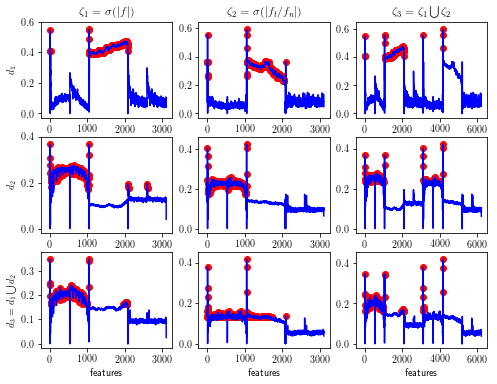

In [13]:
############################### DIMENSIONALITY REDUCTION VIA FEATURE SELECTION #####################################
fig = plt.figure(figsize=(8,6))
r,c = np.array(featsel).shape[0],np.array(featsel).shape[1]
Xfs = {}
matplotlib.rcParams['text.usetex'] = True
for i in range(r):
    Xfs[i] = {}
    for j in range(c):
        Xfs[i][j] = np.array(featsel[i][j].transform(X[i][:,tmpind[j]]))[:,bestix[i][j][:nfeat]]
        print Xfs[i][j].shape
        ax = fig.add_subplot(r,c,i*c+j+1)
        ax.plot(featsel[i][j].scores_,'b')
        ax.scatter(bestix[i][j][:nfeat],featsel[i][j].scores_[bestix[i][j][:nfeat]],color='r')
        if i==0 and j==0:
            ax.set_title(r'$\zeta_1=\sigma(|f|)$')
            ax.set_ylabel(r'$d_1$')
        if i==0 and j==1:
            ax.set_title(r'$\zeta_2=\sigma(|f_t/f_n|)$')
        if i==0 and j==2:
            ax.set_title(r'$\zeta_3=\zeta_1\bigcup \zeta_2$')
        if i==1 and j==0:
            ax.set_ylabel(r'$d_2$')
        if i==2 and j==0:
            ax.set_ylabel(r'$d_3=d_1\bigcup d_2$')
        if i==2:
            ax.set_xlabel('features')
Xfs = np.array([[i for _,i in Xfsi.items()] for _,Xfsi in Xfs.items()])
#plt.show()
savefig('plots/'+featname+'_featsel.png', bbox_inches='tight')
savefig('plots/featureselection.eps',format='eps',dpi=50,bbox_inches='tight')

In [14]:
############################# Computation time of ALL features in secs #############################################
t1 = time.time()
tmpfeat = [feat(prefeat[30][i:i+window,:2],*featparam) for i in range(100)] # avg over 100 times
print (time.time()-t1)/100

0.0588336396217


In [23]:
################################### DIMENSIONALITY REDUCTION #######################################################
featdimredfile = 'features/'+featname+'_dimred'+'.npz'
ncomp = 50
tmpskip = 10
if os.path.isfile(featdimredfile):
    inpdimred = np.load(featdimredfile)
    pca = inpdimred['pca'].tolist()
    Xpca = inpdimred['Xpca']
    tmpix = inpdimred['tmpix']
else:
    # PCA
    r,c = Xfs.shape[0],Xfs.shape[1]
    Xpca,pca,tmpix = {},{},{}
    for i in range(r):
        Xpca[i],pca[i] = {},{}
        tmpix[i] = range(0,Xfs[i][0].shape[0],tmpskip)
        for j in range(c):
            pca[i][j] = PCA(n_components=ncomp, random_state=0)
            pca[i][j].fit(Xfs[i][j][tmpix[i],:])
            Xpca[i][j] = pca[i][j].transform(Xfs[i][j][tmpix[i],:])
    pca = np.array([[i for _,i in pcai.items()] for _,pcai in pca.items()])
    Xpca = np.array([[i for _,i in Xpcai.items()] for _,Xpcai in Xpca.items()])
    tmpix = np.array([i for _,i  in tmpix.items()])
    np.savez(featdimredfile,pca=pca,Xpca=Xpca,tmpix=tmpix)
for i in range(r):
    for j in range(c):
        print Xpca[i][j].shape, np.array(tmpix[i]).shape ,(pca[i][j].explained_variance_ratio_)
        ################################## VISUALIZATION OF DIMENSIONALITY REDUCTION ###############################
        fig = plt.figure(figsize=(6,2))
        fig.suptitle(str(i)+str(j), fontsize=14, fontweight='bold')
        #ax = Axes3D(fig)
        #fig = plt.figure()
        #ax = fig.add_subplot(111, projection='3d')
        ax = fig.add_subplot(141, projection='3d')
        #ax = fig.add_subplot(141)
        ax.scatter(Xpca[i][j][:,0],Xpca[i][j][:,1],Xpca[i][j][:,2],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))
        ax = fig.add_subplot(142)
        ax.scatter(Xpca[i][j][:,0],Xpca[i][j][:,1],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))
        ax = fig.add_subplot(143)
        ax.scatter(Xpca[i][j][:,0],Xpca[i][j][:,2],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))
        ax = fig.add_subplot(144)
        ax.scatter(Xpca[i][j][:,1],Xpca[i][j][:,2],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))

(767, 50) (767,) [  9.95568146e-01   2.27501654e-03   7.78355943e-04   6.67227178e-04
   3.29184150e-04   2.03892713e-04   7.95256307e-05   4.44064303e-05
   2.74751781e-05   9.19344691e-06   5.75850504e-06   3.03192060e-06
   2.29594636e-06   2.13491261e-06   1.59166759e-06   1.26891619e-06
   5.67139055e-07   2.49522916e-07   2.05441428e-07   1.13652032e-07
   8.72734709e-08   7.65458044e-08   4.00200524e-08   3.37855629e-08
   2.48995469e-08   2.00217634e-08   1.59028405e-08   1.16496166e-08
   9.38853777e-09   5.46419386e-09   5.00182852e-09   4.12860233e-09
   3.41453993e-09   2.95445013e-09   2.22399907e-09   1.85791364e-09
   1.72846032e-09   1.25154438e-09   1.09162762e-09   1.04409212e-09
   9.62774754e-10   8.29847038e-10   7.02141643e-10   6.46540418e-10
   5.23260803e-10   5.02864278e-10   4.63466588e-10   4.33332131e-10
   3.32566823e-10   3.17365752e-10]


AttributeError: 'module' object has no attribute '_string_to_bool'

In [24]:
import pip
pp = pip.get_installed_distributions()
for p in sorted([p.location+"\t"+p.project_name+" ("+p.version+")" for p in pp]):
    print p

/opt/ros/indigo/lib/python2.7/dist-packages	actionlib (1.11.7)
/opt/ros/indigo/lib/python2.7/dist-packages	bondpy (1.7.18)
/opt/ros/indigo/lib/python2.7/dist-packages	camera-calibration (1.12.19)
/opt/ros/indigo/lib/python2.7/dist-packages	camera-calibration-parsers (1.11.12)
/opt/ros/indigo/lib/python2.7/dist-packages	catkin (0.6.18)
/opt/ros/indigo/lib/python2.7/dist-packages	cv-bridge (1.11.15)
/opt/ros/indigo/lib/python2.7/dist-packages	diagnostic-analysis (1.8.10)
/opt/ros/indigo/lib/python2.7/dist-packages	diagnostic-common-diagnostics (1.8.10)
/opt/ros/indigo/lib/python2.7/dist-packages	diagnostic-updater (1.8.10)
/opt/ros/indigo/lib/python2.7/dist-packages	dynamic-reconfigure (1.5.46)
/opt/ros/indigo/lib/python2.7/dist-packages	gencpp (0.5.5)
/opt/ros/indigo/lib/python2.7/dist-packages	genlisp (0.4.15)
/opt/ros/indigo/lib/python2.7/dist-packages	genmsg (0.5.7)
/opt/ros/indigo/lib/python2.7/dist-packages	genpy (0.5.10)
/opt/ros/indigo/lib/python2.7/dist-packages	image-geometry (

In [ ]:
######################################## DATASETS PREPARATION ######################################################
datasets = [(Xpca[i][j],Y[i][tmpix[i]]) for j in range(c) for i in range(r)]
print np.array(datasets).shape
for ds in datasets:
    X1,Y1 = ds
    print X1.shape,Y1.shape

In [ ]:
######################################### TRAINING OF ML CLASSIFIERS ###############################################
figure = plt.figure(figsize=(18, 36))
i = 1

clffile = 'trained_classifiers.npz'
if os.path.isfile(clffile):
    clfall = np.load(clffile)['clfall']
    clfpall = np.load(clffile)['clfpall']
else:
    clfall = []
    clfpall = []
# iterate over datasets
start_time = time.time()
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    ncomp = 2
    # Keep the first ncomp of pca of X to visualize the results
    Xp = X[:,:ncomp]

    X_train, X_test, y_train, y_test, Xp_train, Xp_test = train_test_split(X, y, Xp, test_size=.4)
    
    x_min, x_max = Xp[:, 0].min() - .5, Xp[:, 0].max() + .5
    y_min, y_max = Xp[:, 1].min() - .5, Xp[:, 1].max() + .5
    print x_min, x_max, y_min, y_max
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # just pick the colors used to represent the labels first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF']) # red:0 (stable), blue: 1 (slip)
    
    clfmodels = []
    clfpmodels = []
    pred = []
    predp = []
    predts = []
    predpts = []
    score = []
    scorep = []
    scorec = []
    scorepc = []
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        tmpix = (i-1)%len(classifiers)
        ax = plt.subplot(len(datasets)*2, len(classifiers)/2, i)
        if os.path.isfile(clffile):
            clfp = clfpall[i-1]
        else:
            clfp = deepcopy(clf)
        if i%(len(names))!=0:
            if not os.path.isfile(clffile):
                clf.fit(X_train, y_train)
                clfp.fit(Xp_train,y_train)
            if i%(len(names)) == 8: # LASSOCV
                if not os.path.isfile(clffile):
                    model = SelectFromModel(clf, prefit=True)
                else:
                    model = SelectFromModel(clfall[i-1], prefit=True)
                X_new = model.transform(X_train)
                print X_train.shape, X_new.shape
        else: # if classifier is ensemble mlp
            newX_train = np.array(pred).transpose()
            newXp_train = np.array(predp).transpose()
            if not os.path.isfile(clffile):
                clf.fit(newX_train,y_train)
                clfp.fit(newXp_train,y_train)
        if not os.path.isfile(clffile):
            clfmodels += [clf]
        else:
            clfmodels += [clfall[i-1]]
        clfpmodels += [clfp]
        if i%(len(names))!=0:
            if not os.path.isfile(clffile):
                npred = clf.predict(X_test)
            else:
                npred = clfall[i-1].predict(X_test)
            npredp = clfp.predict(Xp_test)
            t1 = time.time()
            score += [sum(((npred>0.5).astype(int)==y_test).astype(int))*1./len(y_test)]
            t2 = (time.time()-t1)
            scorep += [sum(((npredp>0.5).astype(int)==y_test).astype(int))*1./len(y_test)]
            try:
                if not os.path.isfile(clffile):
                    scorec += [cross_val_score(clf,X_test,y_test,cv=CV,scoring=metr)]
                else:
                    scorec += [cross_val_score(clfall[i-1],X_test,y_test,cv=CV,scoring=metr)]
                scorepc += [cross_val_score(clfp,Xp_test,y_test,cv=CV,scoring=metr)]
            except ValueError:
                scorec += [np.array(score[tmpix])]
                scorepc += [np.array([scorep[tmpix]])]      
            if not os.path.isfile(clffile):
                if hasattr(clf, "predict_proba"):
                    pred += [clf.predict_proba(X_train)[:,1]]
                    predts += [clf.predict_proba(X_test)[:,1]]
                else:
                    pred += [clf.predict(X_train)]
                    predts += [clf.predict(X_test)]
            else:
                if hasattr(clf, "predict_proba"):
                    pred += [clfall[i-1].predict_proba(X_train)[:,1]]
                    predts += [clfall[i-1].predict_proba(X_test)[:,1]]
                else:
                    pred += [clfall[i-1].predict(X_train)]
                    predts += [clfall[i-1].predict(X_test)]
            if hasattr(clfp, "predict_proba"):
                predp += [clfp.predict_proba(Xp_train)[:,1]]
                predpts += [clfp.predict_proba(Xp_test)[:,1]]
            else:
                predp += [clfp.predict(Xp_train)]
                predpts += [clfp.predict(Xp_test)]
        else: # if classifier is ensemble MLP
            newX_test = np.array(predts).transpose()
            newXp_test = np.array(predpts).transpose()
            t1 = time.time()
            if not os.path.isfile(clffile):
                score += [clf.score(newX_test, y_test)]
            else:
                score += [clfall[i-1].score(newX_test, y_test)]
            t2 = (time.time()-t1)*1./len(y_test)
            scorep += [clfp.score(newXp_test, y_test)]
            try:
                if not os.path.isfile(clffile):
                    scorec += [cross_val_score(clf,newX_test,y_test,cv=CV,scoring=metr)]
                else:
                    scorec += [cross_val_score(clfall[i-1],newX_test,y_test,cv=CV,scoring=metr)]
                scorepc += [cross_val_score(clfp,newXp_test,y_test,cv=CV,scoring=metr)]
            except ValueError:
                scorec += [np.array(score[tmpix])]
                scorepc += [np.array([scorep[tmpix]])]
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]*[y_min, y_max].
        Zlist = []
        if i%(len(names))!=0:
            if not hasattr(clfp, "predict_proba"):
                Z = clfp.predict(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clfp.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Zlist += [Z]
        else: # if classifier is ensemble MLP
            Z = np.zeros((np.c_[xx.ravel(), yy.ravel()].shape[0]))
            j = 0
            for clfpi in clfpmodels:
                if j >= len(clfmodels)-1:
                    continue
                mult = (clfp.intercepts_[0][:,np.newaxis]*clfp.intercepts_[1]*clfp.intercepts_[2])[:,0]
                if not hasattr(clfpi, "predict_proba"):
                    #Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
                    #Z += clf.intercepts_[0][j]*clfpi.decision_function(np.c_[xx.ravel(), yy.ravel()])
                    #Z += clf.intercepts_[0][j]*clfpi.predict(np.c_[xx.ravel(), yy.ravel()])
                    Z += mult[j]*clfpi.predict(np.c_[xx.ravel(), yy.ravel()])
                else:
                    #Z += clf.intercepts_[0][j]*clfpi.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                    Z += mult[j]*clfpi.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                j += 1
                Zlist += [Z]
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(Xp_train[:, 0], Xp_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(Xp_test[:, 0], Xp_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.min()+0.02*(xx.max()-xx.min()), yy.max()-0.05*(yy.max()-yy.min()), ('%.2f' % scorec[tmpix].mean()).lstrip('0'),
                size=15, horizontalalignment='right')
        ax.text(xx.min()+0.02*(xx.max()-xx.min()), yy.min()+0.01*(yy.max()-yy.min()), ('%.2f' % scorepc[tmpix].mean()).lstrip('0'),
                size=15, horizontalalignment='right')
        print i, scorep[tmpix], score[tmpix], scorepc[tmpix].mean(), scorepc[tmpix].std(),\
               scorec[tmpix].mean(), scorec[tmpix].std() , '--secs:', t2
        i += 1
    if not os.path.isfile(clffile):
        clfall += deepcopy(clfmodels)
        clfpall += deepcopy(clfpmodels)
figure.subplots_adjust(left=.02, right=.98)
print("--- %s seconds ---" % (time.time() - start_time))
#plt.show()
savefig('plots/'+featname+'.png', bbox_inches='tight')

In [ ]:
########################################## Saving/Loading ML Models ################################################
if not os.path.isfile(clffile):
    np.savez(clffile,clfall=np.array(clfall),clfpall=np.array(clfpall))
    np.save('names_classifiers.npy',np.array(names))
else:
    clfall = np.load(clffile)['clfall']
print np.array(clfall).shape

In [ ]:
################################### Computing test inputs for validation ###########################################
ix = [[0,3,6],[1,4,7],[2,5,8]]
dsfile = 'features/'+featname+'_testds'+'.npz'
if os.path.isfile(dsfile):
    ds = np.load(dsfile)['ds']
else:
    ds = {}
    X = np.load(XYfile)['X']
    for i in range(r): # for all datasets (take each scaler and pca)
        ds[i] = {} 
        for j in range(r): # for all datasets as well (transform all of them with the given scaler and pca)
            ds[i][j] = {}
            for k in range(c): # for all feature dimensions
                tmpnorm = S[i][k].transform(X[j][:,tmpind[k]])
                Xfs[i][k] = np.array(featsel[i][k].transform(tmpnorm))[:,bestix[i][k]]
                ds[i][j][k] = pca[i][k].transform(Xfs[i][k]) # transform with pca(i,k) all Xfs(j,k) 
                print i,j,k,Xfs[i][k].shape,ds[i][j][k].shape,Y[j].shape,X[j][:,tmpind[k]].shape,tmpnorm.shape
    ds = np.array([[[dsijk for _,dsijk in dsij.items()] for _,dsij in dsi.items()] for _,dsi in ds.items()])
    np.savez(dsfile,ds=ds)
print ds.shape

In [ ]:
################################### Computing test outputs for evaluation ##########################################
ftsnames = ['sf','ftn','all']
outfile = 'features/'+featname+'_testout_all'+'.npz'
if os.path.isfile(outfile):
    tmpout = np.load(outfile)['tmpout']
    tmpfsc = np.load(outfile)['tmpfsc']
    tmpauc = np.load(outfile)['tmpauc']
else: 
    tmpout = {}
    tmpfsc = {}
    tmpauc = {}
    tmppred = {}
    for i in range(r):
        tmpout[i] = {}
        tmppred[i] = {}
        tmpfsc[i] = {}
        tmpauc[i] = {}
        for j in range(r):
            tmpout[i][j] = {}
            tmpfsc[i][j] = {}
            tmpauc[i][j] = {}
            tmppred[i][j] = {}
            for k in range(c):
                tmpout[i][j][k] = {}
                tmppred[i][j][k] = {}
                tmpfsc[i][j][k] = {}
                tmpauc[i][j][k] = {}
                for l in range(len(names)):
                    if (l+1)%len(names)!=0: # not ensemble
                        tmpout[i][j][k][l] = clfall[ix[i][k]*len(names)+l].score(ds[i][j][k],Y[j])
                        tmppred[i][j][k][l] = clfall[ix[i][k]*len(names)+l].predict(ds[i][j][k])
                    else:
                        tmpin = np.array([tpred for _,tpred in tmppred[i][j][k].items()]).transpose()
                        tmpout[i][j][k][l] = clfall[ix[i][k]*len(names)+l].score(tmpin,Y[j])
                        tmppred[i][j][k][l] = clfall[ix[i][k]*len(names)+l].predict(tmpin)
                    tmpfsc[i][j][k][l] = f1_score(Y[j],np.round(np.divide(np.abs(tmppred[i][j][k][l]),np.amax(np.abs(tmppred[i][j][k][l])))))
                    tmpauc[i][j][k][l] = roc_auc_score(Y[j],np.round(np.divide(np.abs(tmppred[i][j][k][l]),np.amax(np.abs(tmppred[i][j][k][l])))))
                    print i,j,k,l,ds[i][j][k].shape,Y[j].shape,tmpout[i][j][k][l],tmpfsc[i][j][k][l],tmpauc[i][j][k][l]
    tmpout = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmpout.items()])
    tmppred = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmppred.items()])
    tmpfsc = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmpfsc.items()])
    tmpauc = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmpauc.items()])
    np.savez(outfile,tmpout=tmpout,tmppred=tmppred,tmpfsc=tmpfsc,tmpauc=tmpauc)
print tmpout[:,:,:,-1],tmpfsc[:,:,:,-1],tmpauc[:,:,:,-1]

In [ ]:
################################### Computing stats for assessment #################################################
# mean of all test datasets, for each train dataset, for each ft, for each clf
meantsds = np.mean(tmpout,axis=1)
# mean of all test datasets, of all train datasets, for each ft, for each clf
meanft = np.mean(meantsds,axis=0)
# mean of all test datasets, of all ft, for each train dataset, for each clf
meantrds = np.mean(meantsds,axis=1)
# mean of all test datasets, of all train datasets, of all ft, for each clf
meanclf1 = np.mean(meanft,axis=0)
meanclf2 = np.mean(meantrds,axis=0)

print tmpout.shape, meantsds.shape, meanft.shape, meantrds.shape, meanclf1.shape, meanclf2.shape
print '--------------------------------------------------------------------------------------------','ALL'
print 'Best 5 Mean Accuracy of Classifiers for alltestds and alltrainds for each ft: '
maxmeanft = np.array([sorted(zip(map(lambda x: round(x,4), meanft[i,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True) for i in range(meantrds.shape[0])])
print maxmeanft[:,:5,:]
print 'Best 5 Mean Accuracy of Classifiers for alltestds and allft for each trainds: '
maxmeantrds = np.array([sorted(zip(map(lambda x: round(x,4), meantrds[i,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True) for i in range(meantrds.shape[0])])
print maxmeantrds[:,:5,:]
print 'Best 5 Mean Accuracy of Classifiers for alltrainds, alltestds and allft: '
maxmeanclf1 = sorted(zip(map(lambda x: round(x,4), meanclf1),map(lambda x: x[:4], names),range(len(names))),reverse=True)
print maxmeanclf1[:5]
print '--------------------------------------------------------------------------------------------','MaxMeanAll'
for i in range(meantsds.shape[0]):
    for j in range(meantsds.shape[1]):
        print 'Best 5 Mean Accuracy of Classifiers for trainds['+str([i,j])+'], testds['+str([i,j])+'] and ft['+str([i,j])+'] (version with all): '
        maxclf1 = sorted(zip(map(lambda x: round(x,4), meantsds[i,j,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True)
        print maxclf1[:5]
print '--------------------------------------------------------------------------------------------','MaxMeanSelf'
for i in range(tmpout.shape[0]):
    for j in range(tmpout.shape[2]):
        print 'Best 5 Self Accuracy of Classifiers for tmpout['+str([i,i,j])+']: '
        maxclf = sorted(zip(map(lambda x: round(x,4), tmpout[i,i,j,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True)
        print maxclf[:5]
print '--------------------------------------------------------------------------------------------','MaxMeanCross'
for i in range(tmpout.shape[0]):
    for j in range(tmpout.shape[1]):
        for k in range(tmpout.shape[2]):
            if i!=j:
                print 'Best 5 Mean Cross Accuracy of Classifiers for tmpout['+str([i,j,k])+']: '
                maxclf = sorted(zip(map(lambda x: round(x,4), tmpout[i,j,k,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True)
                print maxclf[:5]
print '--------------------------------------------------------------------------------------------','EACH'
for i in range(len(names)):
    print '--------------------------------------------------------------------------------------------',i
    print 'Accuracy of '+str(names[i])+' in classifying (trainds,testds,ft): '
    print tmpout[:,:,:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltestds for each trainds and each ft: '
    print meantsds[:,:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltestds and alltrainds for each ft: '
    print meanft[:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltestds and allft for each trainds: '
    print meantrds[:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltrainds, alltestds and allft: '
    print meanclf1[i],' or mean(', tmpout[-1,:,-1,i],') = ',meantsds[-1,-1,i]